In [1]:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = 'all'

import os
from pathlib import Path
import sys
sys.path.append(os.path.abspath('..'))

import random
import pandas as pd
pd.set_option('display.max_rows', None)
import numpy as np
from tqdm.notebook import tqdm
from collections import Counter

from matplotlib import pyplot as plt
%matplotlib inline

import cv2

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T, models
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
import albumentations as albu

import warnings
warnings.filterwarnings('ignore')

In [2]:
print(f'Setup complete. Using torch {torch.__version__} {torch.cuda.get_device_properties(0)}')

Setup complete. Using torch 2.0.1+cu118 _CudaDeviceProperties(name='NVIDIA GeForce RTX 3050 Laptop GPU', major=8, minor=6, total_memory=4095MB, multi_processor_count=16)


### Датасет можно скачать по ссылке с kaggle

https://www.kaggle.com/datasets/gpiosenka/sports-classification

In [3]:
DATA_PATH = '../data_sports'

path_train_jpg = os.path.join(DATA_PATH, 'train') 
path_classes = os.path.join(DATA_PATH, 'sports.csv')

# Count folders and files in each folder inside DATA_PATH
folder_count = 0
file_count = 0

for root, dirs, files in os.walk(DATA_PATH):
    folder_count += len(dirs)
    file_count += len(files)

print(f"Number of folders in {DATA_PATH}: {folder_count}")
print(f"Number of files in {DATA_PATH}: {file_count}")


Number of folders in ../data_sports: 303
Number of files in ../data_sports: 14502


In [4]:
df_classes = pd.read_csv(path_classes)
print(df_classes.shape)
df_classes.head(5)

(14493, 4)


,class id,filepaths,labels,data set
0,0,train/air hockey/001.jpg,air hockey,train
1,0,train/air hockey/002.jpg,air hockey,train
2,0,train/air hockey/003.jpg,air hockey,train
3,0,train/air hockey/004.jpg,air hockey,train
4,0,train/air hockey/005.jpg,air hockey,train


In [5]:
df_classes = df_classes[df_classes['data set'] == 'train']
df_classes['labels'].value_counts()[:20]

labels
football                191
formula 1 racing        190
nascar racing           189
baseball                174
hockey                  172
basketball              169
olympic wrestling       167
rugby                   166
canoe slamon            164
roller derby            163
rollerblade racing      159
high jump               159
figure skating women    157
field hockey            157
golf                    157
polo                    157
rings                   157
swimming                157
uneven bars             156
lacrosse                151
Name: count, dtype: int64

### Возьмем в работу первые 30 классов и оставим по 30 картинок в классе

In [6]:
classes_10 = df_classes['labels'].value_counts().index.to_list()[:30]
len(classes_10)

30

In [7]:
label_dict = {k:v for v, k in enumerate(classes_10)}
label_dict

{'football': 0,
 'formula 1 racing': 1,
 'nascar racing': 2,
 'baseball': 3,
 'hockey': 4,
 'basketball': 5,
 'olympic wrestling': 6,
 'rugby': 7,
 'canoe slamon': 8,
 'roller derby': 9,
 'rollerblade racing': 10,
 'high jump': 11,
 'figure skating women': 12,
 'field hockey': 13,
 'golf': 14,
 'polo': 15,
 'rings': 16,
 'swimming': 17,
 'uneven bars': 18,
 'lacrosse': 19,
 'figure skating pairs': 20,
 'giant slalom': 21,
 'judo': 22,
 'shot put': 23,
 'bull riding': 24,
 'skydiving': 25,
 'snowmobile racing': 26,
 'balance beam': 27,
 'harness racing': 28,
 'billiards': 29}

In [8]:
df_10 = df_classes[df_classes['labels'].isin(classes_10)]
df_10 = df_10.groupby('labels').apply(lambda x: x.sample(n=30))
df_10.reset_index(drop=True, inplace=True)

In [9]:
df_10['labels'].value_counts()

labels
balance beam            30
baseball                30
swimming                30
snowmobile racing       30
skydiving               30
shot put                30
rugby                   30
rollerblade racing      30
roller derby            30
rings                   30
polo                    30
olympic wrestling       30
nascar racing           30
lacrosse                30
judo                    30
hockey                  30
high jump               30
harness racing          30
golf                    30
giant slalom            30
formula 1 racing        30
football                30
figure skating women    30
figure skating pairs    30
field hockey            30
canoe slamon            30
bull riding             30
billiards               30
basketball              30
uneven bars             30
Name: count, dtype: int64

In [10]:
df_10['label_num'] = df_10['labels']
df_10['label_num'].replace(label_dict, inplace=True)
df_10['label_num']=df_10['label_num'].astype('int8')

In [11]:
df_10 = df_10.drop(columns=['class id', 'data set'])
df_10.to_csv(Path(DATA_PATH) / 'train_set_10.csv', index=False)

In [12]:
# Add column with image size
df_10['im_size'] = None
for i, row in df_10.iterrows():
    img_path = Path(DATA_PATH) / row['filepaths']
    image = cv2.imread(str(img_path))  # Convert img_path to string
    if image is not None:
        height, width, _ = image.shape
        df_10.at[i, 'im_size'] = (height, width)
df_10.sample(3)

,filepaths,labels,label_num,im_size
360,train/golf/137.jpg,golf,14,"(224, 224)"
367,train/golf/138.jpg,golf,14,"(224, 224)"
277,train/football/173.jpg,football,0,"(224, 224)"


In [13]:
df_10.im_size.value_counts()

im_size
(224, 224)    900
Name: count, dtype: int64

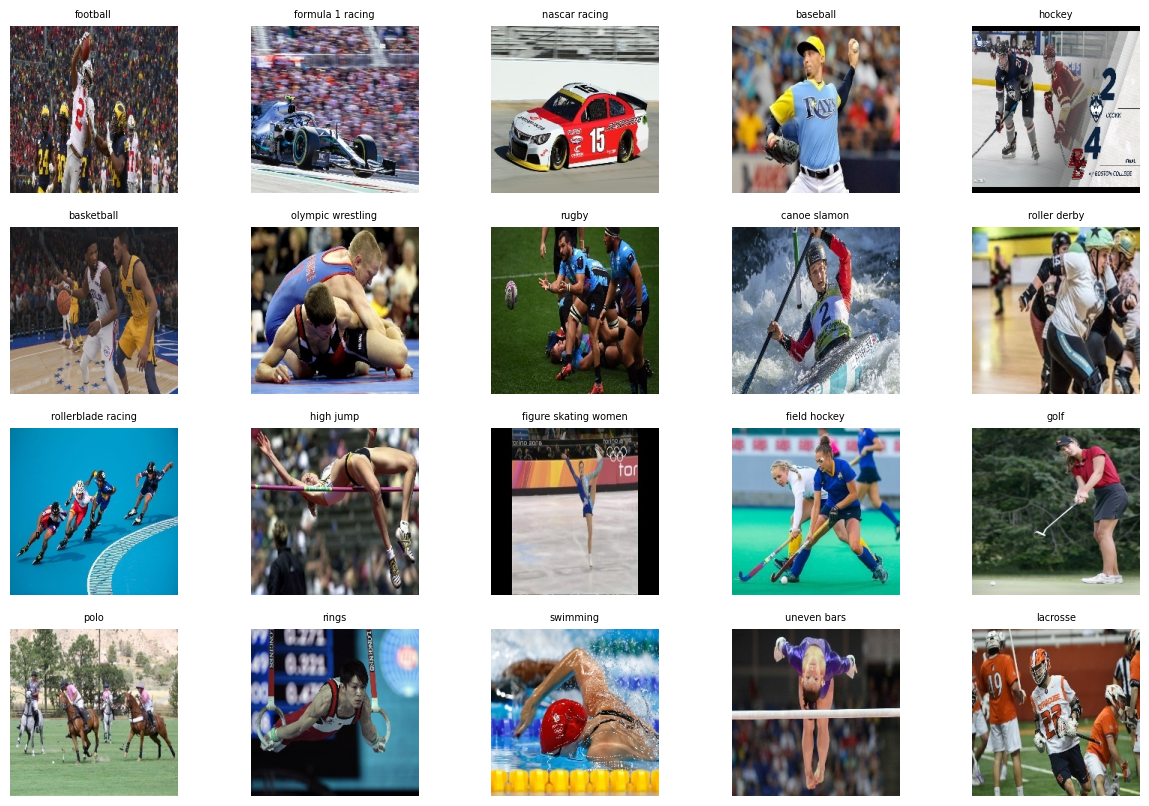

In [14]:
# Visualize images from diferent classes
plt.figure(figsize=(15, 10))
for ind, lbl in enumerate(classes_10):
    filename = random.choice(df_10[df_10['labels'].isin([lbl])]['filepaths'].values)
    img_path = os.path.join(DATA_PATH, filename)
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(4, 5, ind + 1)
    ax.set_title(lbl, fontsize = 7)
    ax.imshow(image)
    ax.axis('off')
    if ind > 18:
        break
    
plt.show()